In [1]:
import core as mqm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nsites = 2
npart = 1
nmodes = 1
hsf = mqm.BasicFermions.firstdet(npart, nsites)
hsb = mqm.BasicBosons.firstdet(nmodes, [2])
hs = hsf*hsb*hsf

In [3]:
det = hsf.copy()
det.array = np.array([1,0,0,0,1])
perm = hsb.copy()
perm.array = np.array([1])


TypeError: 'BasicFermions' object does not support item assignment

In [12]:
for state in hs.range():
    print(state)

[[1, 0], [0]]
[[1, 0], [1]]
[[1, 0], [2]]
[[0, 1], [0]]
[[0, 1], [1]]
[[0, 1], [2]]


In [ ]:
    from scipy.sparse.linalg import eigs

    sdet = BasicFermions.firstdet(1,2)
    det = sdet*sdet

    U = 4
    ############# exact hamiltonian #############
    ht = chain(U,-1/2,2,periodic=False)
    ht= ht + vterm(1.5,0,0)
    ht= ht + vterm(1.5,1,0)
    ht= ht + vterm(-1.5,0,1)
    ht= ht + vterm(-1.5,1,1)
    # transforms into a csr format
    ht_csr = hlist_to_csr(ht,det)
    print(ht_csr.toarray())
    val = eigs(ht_csr,k=1,which='SR',return_eigenvectors=False)
    print(val)

    ############# HF hamiltonian #############
    orb, eigval = solve_HF(ht,2,[2,2],0.00000001)
    print(orb)
    print(eigval)
    occup = np.zeros(np.size(orb,0))
    occup[:2] = 1

    # HF energy using density matrix
    hfenergy = HFenergy(ht,det.nsiteslist,orb,occup)
    print(hfenergy)

    # HF energy computing from ket (works only for restricted HF)
    ket = orb_to_ket(orb,occup,det)
    print(ket)
    print(np.dot(ket,ket))
    print(np.dot(ket,apply_to_ket(ht,ket,det)))

In [8]:
sdet = mqm.BasicFermions.firstdet(1,2)
det = sdet*sdet

In [12]:
Uval = 10
tval = 0.5
deltav = -15

In [13]:
ha = []
ha = ha + mqm.uterm(Uval,0,1,0)
ha = ha + mqm.uterm(Uval,0,1,1)
ha = ha + mqm.tterm(-tval,0,0,1) + mqm.tterm(-tval,1,0,1)
hamat = mqm.hlist_to_csr(ha,det).toarray()
print(hamat)

[[10. +0.j -0.5+0.j -0.5+0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]
 [-0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j -0.5+0.j -0.5+0.j 10. +0.j]]


In [14]:
dnop = [[1, [[0, 1, 1], [0, 1, -1]]]]
dnop = dnop + [[1, [[1, 1, 1], [1, 1, -1]]]]
dnop = dnop + [[-1, [[0, 0, 1], [0, 0, -1]]]]
dnop = dnop + [[-1, [[1, 0, 1], [1, 0, -1]]]]
dnmat = mqm.hlist_to_csr(dnop,det).toarray()
print(dnmat)

[[-2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j]]


In [15]:
enerlist, eigvec = np.linalg.eigh(hamat)
print(enerlist)
print(eigvec)
Psi0 = eigvec[:,0]
dn0 = np.real(np.dot(Psi0.conjugate(),dnmat@Psi0))
print(dn0)
print(f'omega = {enerlist[2]-enerlist[0]}, T = {2*np.pi/(enerlist[2]-enerlist[0])}')

[-0.09901951  0.         10.         10.09901951]
[[ 6.96766179e-02-0.j  0.00000000e+00+0.j  7.07106781e-01+0.j  7.03665523e-01+0.j]
 [ 7.03665523e-01+0.j  7.07106781e-01+0.j -1.60437112e-16+0.j -6.96766179e-02+0.j]
 [ 7.03665523e-01+0.j -7.07106781e-01+0.j -1.60437112e-16+0.j -6.96766179e-02+0.j]
 [ 6.96766179e-02+0.j  0.00000000e+00+0.j -7.07106781e-01+0.j  7.03665523e-01+0.j]]
-4.206097375217845e-18
omega = 10.099019513592786, T = 0.6221579529302549


In [24]:
def ee_pipulse(tt, width = 50, w0 = 5.176):
    sigma = width
    f0 = np.pi/(sigma*np.sqrt(w0))
    f0 = 2*f0
    tp = sigma + 0.1
    return np.where(abs(tt-tp)<sigma,
                    f0*(np.cos((np.pi/(2*sigma))*(tt-tp))**2)*np.cos(w0*(tt-tp)),
                    0)


w0 =  (enerlist[2]-enerlist[0])
ee = lambda tt : ee_pipulse(tt, w0 = w0)

dt = 0.05
ttmax = 100
tt_tarr = np.arange(0,ttmax,dt)

In [25]:
import timeprop
dn_tarr = []
tt_tarr = []

Psi = Psi0



for tt in np.arange(0,ttmax,dt) :
    ## observable
    dnt = np.real(np.dot(Psi.conjugate(),dnmat@Psi))
    dn_tarr.append(dnt)
    ## time vector
    tt_tarr.append(tt)
    ## define hamiltonian
    ht = ha + mqm.vterm(-ee(tt)/2,0,0) + mqm.vterm(-ee(tt)/2,1,0)
    ht = ht + mqm.vterm(ee(tt)/2,0,1) + mqm.vterm(ee(tt)/2,1,1)
    hamat = mqm.hlist_to_csr(ht,det).toarray()
    ## one time step
    Psi = timeprop.psi_timestep(Psi,hamat,dt)

    
    
dn_tarr = np.array(dn_tarr)
tt_tarr = np.array(tt_tarr)    

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_375654/702704270.py:2: SyntaxWarning: invalid escape sequence '\D'
  line1, = ax.plot(tt_tarr, dn_tarr, label='$\Delta n_{\mathrm{exact}}$', linewidth=2.0, alpha=0.5)
/tmp/ipykernel_375654/702704270.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta n$')


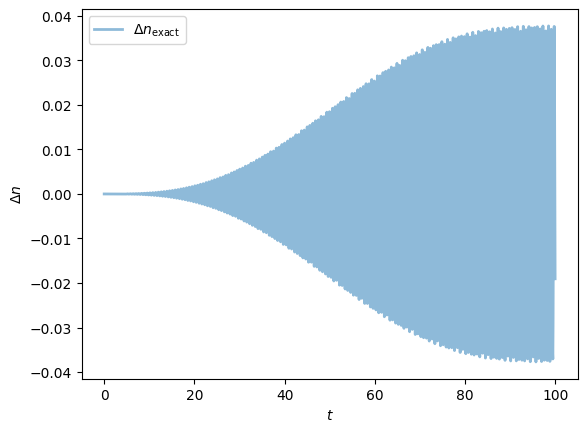

In [26]:
fig, ax = plt.subplots()
line1, = ax.plot(tt_tarr, dn_tarr, label='$\Delta n_{\mathrm{exact}}$', linewidth=2.0, alpha=0.5)
# line1, = ax.plot(tt_tarr, np.zeros_like(tt_tarr), label='$\Delta n_{\mathrm{exact}}$', linewidth=2.0, alpha=0.5)


plt.ylabel('$\Delta n$')
plt.xlabel('$t$')
ax.legend()

plt.show()